# Review of line fitting

In [18]:
import jax
import jax.numpy as jnp
import tqdm

import blackjax

rng_key = jax.random.PRNGKey(0)

d = 20

C = jax.random.normal(rng_key, (d, d)) * 0.1 # draws a random dxd matrix of number from a normal dist., scaled by 0.1
like_cov = C @ C.T # makes the covariance matrix positive definite, covariances of variables
like_mean = jax.random.normal(rng_key, (d,)) # draws a random d-dimensional mean vector from a normal distribution, expected value of each variable

prior_mean = jnp.zeros(d) # prior mean vector of zeros
prior_cov = jnp.eye(d) * 1 # prior covariance matrix as identity matrix scaled by 1

In [19]:
logprior_density = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
    x, prior_mean, prior_cov
)

loglikelihood_function = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
    x, like_mean, like_cov
) # calculates the log-likelihood of x given the likelihood mean and covariance

# def loglikelihood_function(x):
#     return jax.scipy.stats.multivariate_normal.logpdf(x, like_mean, like_cov)

rng_key, prior_sample_key = jax.random.split(rng_key)
n_live = 1000
initial_population = jax.random.multivariate_normal(
    prior_sample_key, prior_mean, prior_cov, (n_live,)
)

In [45]:
num_inner_steps = 3 * d
num_delete = int(n_live*0.1)

algo = blackjax.nss(
    logprior_fn=logprior_density,
    loglikelihood_fn=loglikelihood_function,
    num_delete=num_delete,
    num_inner_steps=num_inner_steps,
)

state = algo.init(initial_population)

In [47]:
from blackjax.ns.base import NSState
from blackjax.ns.base import NSInfo


In [48]:
@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = algo.step(subk, state)
    return (state, k), dead_point

In [49]:
dead = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state.logZ_live - state.logZ < -3:
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead.append(dead_info)
        pbar.update(num_delete)

Dead points: 35700 dead points [00:07, 5061.59 dead points/s] 


In [51]:
from blackjax.ns.utils import log_weights, finalise, sample, ess

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state = finalise(state,dead)
log_w = log_weights(weight_key, final_state, shape=100)
samples = sample(sample_key, final_state, shape = n_live)
ns_ess = ess(sample_key, final_state)

logzs = jax.scipy.special.logsumexp(log_w, axis=0)

In [52]:
from jax.scipy.linalg import solve_triangular, cho_solve

def compute_logZ(mu_L, Sigma_L, logLmax=0, mu_pi=None, Sigma_pi=None):
    """
    Compute log evidence, posterior covariance, and posterior mean.
    
    Args:
        mu_L: Likelihood mean
        Sigma_L: Likelihood covariance
        logLmax: Maximum log likelihood value
        mu_pi: Prior mean
        Sigma_pi: Prior covariance
    
    Returns:
        Tuple of (log evidence, posterior covariance, posterior mean)
    """
    # Use Cholesky decomposition for more stable calculations
    L_pi = jnp.linalg.cholesky(Sigma_pi)
    L_L = jnp.linalg.cholesky(Sigma_L)
    
    # Compute precision matrices (inverse covariances)
    prec_pi = cho_solve((L_pi, True), jnp.eye(L_pi.shape[0]))
    prec_L = cho_solve((L_L, True), jnp.eye(L_L.shape[0]))
    
    # Compute posterior precision and its Cholesky factor
    prec_P = prec_pi + prec_L
    L_P = jnp.linalg.cholesky(prec_P)
    
    # Compute Sigma_P using Cholesky factor
    Sigma_P = cho_solve((L_P, True), jnp.eye(L_P.shape[0]))
    
    # Compute mu_P more stably
    b = cho_solve((L_pi, True), mu_pi) + cho_solve((L_L, True), mu_L)
    mu_P = cho_solve((L_P, True), b)
    
    # Compute log determinants using Cholesky factors
    logdet_Sigma_P = -2 * jnp.sum(jnp.log(jnp.diag(L_P)))
    logdet_Sigma_pi = 2 * jnp.sum(jnp.log(jnp.diag(L_pi)))
    
    # Compute quadratic forms using Cholesky factors
    diff_pi = mu_P - mu_pi
    diff_L = mu_P - mu_L
    quad_pi = jnp.sum(jnp.square(solve_triangular(L_pi, diff_pi, lower=True)))
    quad_L = jnp.sum(jnp.square(solve_triangular(L_L, diff_L, lower=True)))
    
    return (
        (
            logLmax
            + logdet_Sigma_P / 2
            - logdet_Sigma_pi / 2
            - quad_pi / 2
            - quad_L / 2
        ),
        Sigma_P,
        mu_P,
    )

log_analytic_evidence, post_cov, post_mean = compute_logZ(
    like_mean,
    like_cov,
    mu_pi=prior_mean,
    Sigma_pi=prior_cov,
    logLmax=loglikelihood_function(like_mean),
)

print(f"ESS: {int(ns_ess)}")
print(f"logZ estimate: {logzs.mean():.2f} +- {logzs.std():.2f}")
print(f"analytic logZ: {log_analytic_evidence:.2f}")

ESS: 10717
logZ estimate: -32.05 +- 0.17
analytic logZ: -32.09


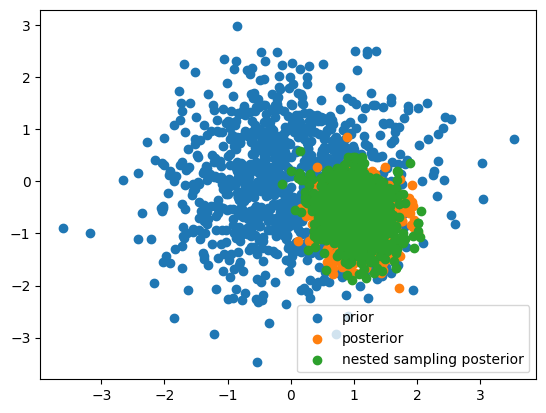

In [53]:
import matplotlib.pyplot as plt

posterior_truth = jax.random.multivariate_normal(
    rng_key, post_mean, post_cov, (n_live,)
)

plt.scatter(
    initial_population[..., 0], initial_population[..., 1], label="prior"
)
plt.scatter(
    posterior_truth[..., 0], posterior_truth[..., 1], label="posterior"
)
plt.scatter(
    samples[..., 0], samples[..., 1], label="nested sampling posterior"
)
plt.legend()